In [1]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

class Brain_Mri_Model(nn.Module):

    def __init__(self):
        super(Brain_Mri_Model , self).__init__()

        self.architecture = smp.Unet(
            encoder_name='resnet34',
            encoder_weights='imagenet',
            classes=1,
            in_channels=3,
            activation=None
        )

    def forward(self, images, masks = None):
        outputs = self.architecture(images)
        if masks is not None:
            loss = DiceLoss(mode = 'binary')(outputs, masks)
            return outputs, loss
        else:
            return outputs

In [2]:
import torch
segmentation_model = Brain_Mri_Model()
segmentation_model.load_state_dict(torch.load('best_model.pth'))
segmentation_model.eval()

Brain_Mri_Model(
  (architecture): Unet(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
         

In [3]:
import tensorflow as tf
import os
tumor_detection_model = tf.keras.models.load_model('detect_tumor_model')

In [4]:
labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

In [5]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import anvil.server
import anvil.media
from PIL import Image
import io


def detect_tumor_inference():
    image = cv2.imread('tempfiles/brain_mri.png', cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (256, 256))
    image = np.expand_dims(image, axis=0)
    image = np.expand_dims(image, axis=3)
    prediction = tumor_detection_model.predict(image)
    prediction = np.argmax(prediction)
    detect_label = labels[prediction]
    plt.imshow(image[0,:,:,0], cmap="gray")
    plt.title(detect_label)
    plt.axis('off')
    plt.savefig("tempfiles/brain_tumor_detect.png")
    return detect_label

def segment_inference() :
    
    image = cv2.imread('tempfiles/brain_mri.png')
    #check if it is grayscale
    if len(image.shape) == 2:
        image = cv2.imread('tempfiles/brain_mri.png', cv2.IMREAD_GRAYSCALE)
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    
    image = cv2.resize(image, (256, 256))
    image = image / 255.0

    image = torch.from_numpy(image).float()
    
    image = image.permute(2, 0, 1)
    outputs = segmentation_model(image.unsqueeze(0))
    
    pred_mask = torch.sigmoid(outputs)
    pred_mask = (pred_mask > 0.5)*1.0
    pred_mask = pred_mask.squeeze().cpu().numpy()
    pred_mask = pred_mask * 255
    
    cv2.imwrite("tempfiles/pred_mask.png", pred_mask)
    # check if the mask is empty
    if np.sum(pred_mask) == 0:
        segment_label = 'notumor'
        return segment_label
    return 0

def display_picture(image_path):
    image = cv2.imread(image_path)
    plt.imshow(image)
    plt.show()


Connecting to wss://anvil.works/uplink
Anvil websocket open
Connected to "Default environment" as SERVER


KeyboardInterrupt: 

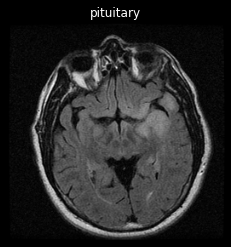

In [6]:
anvil.server.connect("YOUR CODE")

@anvil.server.callable
def anvil_inference(image_file):

    image_object = Image.open(io.BytesIO(image_file.get_bytes()))
    image_object.save("tempfiles/brain_mri.png")

    a = segment_inference()
    b = detect_tumor_inference()
        
    pred_mask = Image.open("tempfiles/pred_mask.png")
    bs = io.BytesIO()
    name = 'pred_mask'
    pred_mask.save(bs, format='PNG')

    brain_mri_scan = Image.open("tempfiles/brain_mri.png")
    bs1 = io.BytesIO()
    name1 = 'brain_mri_scan'
    brain_mri_scan.save(bs1, format='PNG')

    brain_tumor_detect = Image.open("tempfiles/brain_tumor_detect.png")
    bs2 = io.BytesIO()
    name2 = 'brain_tumor_detect'
    brain_tumor_detect.save(bs2, format='PNG')
    text = "Predicted Tumor type is " + b

    if a != 'notumor' :
        if b == 'notumor':
            null = Image.open("tempfiles/black.png")
            bs3 = io.BytesIO()
            name3 = 'null'
            null.save(bs3, format='PNG')
            return anvil.BlobMedia("image/png" , bs.getvalue()), anvil.BlobMedia("image/png" , bs1.getvalue()), anvil.BlobMedia("image/png" , bs3.getvalue()), text
    
    return anvil.BlobMedia("image/png" , bs.getvalue(), name=name), anvil.BlobMedia("image/png" , bs1.getvalue(), name=name1), anvil.BlobMedia("image/png" , bs2.getvalue(), name=name2), text

anvil.server.wait_forever()